# Libraries import

In [19]:
import pandas as pd
import numpy as np
import pickle
from functions.cleaning import cleaning
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model  import LogisticRegression

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Import of clean data

In [3]:
df = cleaning()

# Partitioning

In [4]:
X = df.drop(columns=['EVENT_LABEL'])
y = df['EVENT_LABEL']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [5]:
df.head()

,transaction_amt,transaction_adj_amt,historic_velocity,currency,signature_image,transaction_type,transaction_env,tranaction_initiate,inital_amount,EVENT_LABEL,browser,os,acc_age,d_last_logon
0,2167.0,56.0,2572.0,cad,F,U,X,O,13646.0,0,Opera,Windows,4,3
1,2045.0,48.0,4517.0,cad,X,H,W,J,11930.0,0,Opera,Linux,3,1
2,2892.0,61.0,5007.0,cad,Q,X,X,T,7412.0,0,Mozilla,Linux,7,5
3,3040.0,28.0,6022.0,usd,G,C,N,M,4623.0,0,Mozilla,Macintosh,3,2
4,2976.0,66.0,2600.0,cad,F,F,G,K,1905.0,0,Mozilla,Linux,4,2


In [6]:
df['transaction_amt'].min()

5.0

# Logistic Regression

## Under sampling

### Preprocess

In [7]:
num_labels_u_lr = X_train.select_dtypes('number').columns
cat_labels_u_lr = X_train.select_dtypes('object').columns

under_sampler_u_lr = RandomUnderSampler()
num_preprocess_u_lr = StandardScaler()
cat_preprocess_u_lr = OneHotEncoder(drop='first', handle_unknown='ignore')
svd_u_lr = TruncatedSVD()
preprocessor_u_lr = ColumnTransformer([('cat', cat_preprocess_u_lr, cat_labels_u_lr),
                                  ('num', num_preprocess_u_lr, num_labels_u_lr)])

### Model

In [8]:
LogReg_u_lr = LogisticRegression(solver='saga', max_iter=100000)

### Pipeline

In [9]:
u_lr = Pipeline([('under_sampler', under_sampler_u_lr),
                 ('pre', preprocessor_u_lr),
                 ('svd', svd_u_lr),
                 ('model', LogReg_u_lr)])
u_lr.fit(X_train, y_train)

Pipeline(steps=[('under_sampler', RandomUnderSampler()),
                ('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['currency', 'signature_image', 'transaction_type', 'transaction_env',
       'tranaction_initiate', 'browser', 'os', 'acc_age', 'd_last_logon'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['transaction_amt', 'transaction_adj_amt', 'historic_velocity',
       'inital_amount'],
      dtype='object'))])),
                ('svd', TruncatedSVD()),
                ('model', LogisticRegression(max_iter=100000, solver='saga'))])

## Over sampling

### Preprocess

In [10]:
num_labels_o_lr = X_train.select_dtypes('number').columns
cat_labels_o_lr = X_train.select_dtypes('object').columns

over_sampler_o_lr = RandomOverSampler(sampling_strategy='minority')
num_preprocess_o_lr = StandardScaler()
cat_preprocess_o_lr = OneHotEncoder(drop='first')
svd_o_lr = TruncatedSVD()
preprocessor_o_lr = ColumnTransformer([('cat', cat_preprocess_o_lr, cat_labels_o_lr),
                                  ('num', num_preprocess_o_lr, num_labels_o_lr)])

### Model

In [11]:
LogReg_o_lr = LogisticRegression(solver='lbfgs', max_iter=100000)

### Pipeline

In [12]:
o_lr = Pipeline([('over_sampler', over_sampler_o_lr),
                 ('pre', preprocessor_o_lr),
                 ('svd', svd_o_lr),
                 ('model', LogReg_o_lr)])
o_lr.fit(X_train, y_train)

Pipeline(steps=[('over_sampler',
                 RandomOverSampler(sampling_strategy='minority')),
                ('pre',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['currency', 'signature_image', 'transaction_type', 'transaction_env',
       'tranaction_initiate', 'browser', 'os', 'acc_age', 'd_last_logon'],
      dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['transaction_amt', 'transaction_adj_amt', 'historic_velocity',
       'inital_amount'],
      dtype='object'))])),
                ('svd', TruncatedSVD()),
                ('model', LogisticRegression(max_iter=100000))])

# Evaluation

In [23]:
X_test.shape

(29854, 13)

In [13]:
under_lr = u_lr.predict(X_test)
over_lr = o_lr.predict(X_test)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [15]:
print(accuracy_score(y_test, under_lr))
print(accuracy_score(y_test, over_lr))

0.6024653312788906
0.604240637770483


In [14]:
print(classification_report(y_test, under_lr))
print(classification_report(y_test, over_lr))



              precision    recall  f1-score   support

           0       0.97      0.60      0.74     28270
           1       0.08      0.64      0.15      1584

    accuracy                           0.60     29854
   macro avg       0.53      0.62      0.44     29854
weighted avg       0.92      0.60      0.71     29854

              precision    recall  f1-score   support

           0       0.97      0.60      0.74     28270
           1       0.08      0.66      0.15      1584

    accuracy                           0.60     29854
   macro avg       0.53      0.63      0.45     29854
weighted avg       0.92      0.60      0.71     29854



In [21]:
conf_matrix = confusion_matrix(y_test, over_lr)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[16999 11271]
 [  544  1040]]


In [17]:
conf_matrix = confusion_matrix(y_test, under_lr)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[16965 11305]
 [  563  1021]]


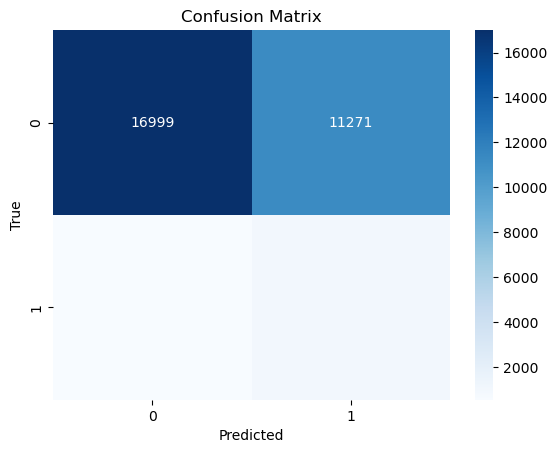

In [22]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()